In [82]:
import random
import shutil
import time
import warnings
import sys
import torch
import os
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.nn.init as init
import os
import PIL.Image
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [83]:
#Model
class Conv_Bn_Relu_Block(nn.Module):
    def __init__(self, n_stages, n_filters_in, n_filters_out):
        super(Conv_Bn_Relu_Block, self).__init__()
        stage = []
        for i in range(n_stages):
            if i == 0:
                input_channel = n_filters_in
            else:
                input_channel = n_filters_out
                
            stage.append(nn.Conv3d(input_channel, n_filters_out, 3, padding=1))
            stage.append(nn.BatchNorm3d(n_filters_out)) 
            stage.append(nn.ReLU(inplace= True))
        self.conv = nn.Sequential(*stage)
                
    def forward(self, x):
        x = self.conv(x)
        return x
    
class Downsampling(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, stride=2):
        super(Downsampling, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv3d(n_filters_in, n_filters_out, stride, padding=0),
                nn.BatchNorm3d(n_filters_out),
                nn.ReLU(inplace= True))

    def forward(self, x):
        x = self.conv(x)
        return x
    
class Upsampling(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, stride=2):
        super(Upsampling, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose3d(n_filters_in, n_filters_out, stride, padding=0),
            nn.BatchNorm3d(n_filters_out),
            nn.ReLU(inplace= True))

    def forward(self, x):
        x = self.conv(x)
        return x
 
       
    
class Res3DUnet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, n_filters=16, drop=False):
        super(Res3DUnet, self).__init__()
        self.drop = drop
        self.b1 = Conv_Bn_Relu_Block(1, n_channels, n_filters)
        self.d1 = Downsampling(n_filters, 32)
        self.b2 = Conv_Bn_Relu_Block(2, 32, 32)
        self.d2 = Downsampling(32, 64)
        self.b3 = Conv_Bn_Relu_Block(3, 64, 64)
        self.d3 = Downsampling(64, 128)
        self.b4 = Conv_Bn_Relu_Block(3, 128, 128)
        self.d4 = Downsampling(128, 256)

        self.b5 = Conv_Bn_Relu_Block(3, 256, 256)
        self.u5 = Upsampling(256, 128)
        self.b6 = Conv_Bn_Relu_Block(3, 128, 128)
        self.u6 = Upsampling(128, 64)
        self.b7 = Conv_Bn_Relu_Block(3, 64, 64)
        self.u7 = Upsampling(64, 32)
        self.b8 = Conv_Bn_Relu_Block(2, 32, 32)
        self.u8 = Upsampling(32, n_filters)
        self.b9 = Conv_Bn_Relu_Block(1, n_filters, n_filters)
        self.out = nn.Conv3d(n_filters, n_classes, 1, padding=0)
        self.drop = nn.Dropout3d(p=0.5, inplace=False)
        
    def forward(self, input, turnoff_drop=False):
        if turnoff_drop:
            drop = self.drop
            self.drop = False
        #encoder
        x1 = self.b1(input)
        x1_ds = self.d1(x1)

        x2 = self.b2(x1_ds)
        x2_ds = self.d2(x2)

        x3 = self.b3(x2_ds)
        x3_ds = self.d3(x3)

        x4 = self.b4(x3_ds)
        x4_ds = self.d4(x4)

        x5 = self.b5(x4_ds)
        
        #decoder
        x5_up = self.u5(x5)
        x5_up = x5_up + x4

        x6 = self.b6(x5_up)
        x6_up = self.u6(x6)
        x6_up = x6_up + x3

        x7 = self.b7(x6_up)
        x7_up = self.u7(x7)
        x7_up = x7_up + x2

        x8 = self.b8(x7_up)
        x8_up = self.u8(x8)
        x8_up = x8_up + x1
        x9 = self.b9(x8_up)

        out = self.out(x9)
        
        if turnoff_drop:
            self.drop = drop
        return out

In [84]:
import torch
import h5py
from torch.utils.data import Dataset
import os

def read_h5(path):
    data = h5py.File(path, 'r')
    image = data['image'][:]
    label = data['label'][:]
    return image, label


In [86]:
class LAHeart(Dataset):
    def __init__(self, split='train',label = True, transform=None):
        self.root = f'./datas/{split}'
        self.transform = transform
        self.label = label
        self.split = split
        self.path_list = os.listdir(self.root)
        self.path_list = [item.replace('\n','') for item in self.path_list]

    def __len__(self):
        return len(self.path_list)   

    def __getitem__(self, index):
        image_name = self.path_list[index]
        path = os.path.join(self.root, self.path_list[index])
        image, label = read_h5(path)
        #print(type(image))
        #print(type(label))
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [87]:
LAHeart()

In [88]:
lah = LAHeart()
print(lah.path_list)
print(len(lah.path_list))
print(lah.path_list[2])
#print(lah[1])

['5BHTH9RHH3PQT913I59W.h5', '78NJ5YFQF72BGC8RO51C.h5', 'A11O45O3NAXWM7T2H8CH.h5', 'AT5CRO5JUDBWD4RUPXSQ.h5', 'BYSRSI3H4YTWKMM3MADP.h5', 'CBIJFVZ5L9BS0LKWE8YL.h5', 'E2ZMO66WGS74UKXTZPPQ.h5', 'GSC9KNY0VEZXFSGWNF25.h5', 'HVE7DR3CUA2IM3RC6OMA.h5', 'IJJY51YW3W4YJJ7DTVTK.h5', 'KM5RYAMP4P4ZP6XWP3Q2.h5', 'KSNYHUBHHUJTYJ14UQZR.h5', 'OIRDLE32TXZX942FVZMM.h5', 'P1OTI3IWJUIB5NRLULLH.h5']
14
A11O45O3NAXWM7T2H8CH.h5


In [89]:
class RandomCrop(object):

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if label.shape[0] <= self.output_size[0] or label.shape[1] <= self.output_size[1] or label.shape[2] <= \
                self.output_size[2]:
            pw = max((self.output_size[0] - label.shape[0]) // 2 + 3, 0)
            ph = max((self.output_size[1] - label.shape[1]) // 2 + 3, 0)
            pd = max((self.output_size[2] - label.shape[2]) // 2 + 3, 0)
            image = np.pad(image, [(pw, pw), (ph, ph), (pd, pd)], mode='constant', constant_values=0)
            label = np.pad(label, [(pw, pw), (ph, ph), (pd, pd)], mode='constant', constant_values=0)

        (w, h, d) = image.shape
        w1 = np.random.randint(0, w - self.output_size[0])
        h1 = np.random.randint(0, h - self.output_size[1])
        d1 = np.random.randint(0, d - self.output_size[2])

        label = label[w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]
        image = image[w1:w1 + self.output_size[0], h1:h1 + self.output_size[1], d1:d1 + self.output_size[2]]
        return {'image': image, 'label': label}


class RandomRotFlip(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        k = np.random.randint(0, 4)
        image = np.rot90(image, k)
        label = np.rot90(label, k)
        axis = np.random.randint(0, 2)
        image = np.flip(image, axis=axis).copy()
        label = np.flip(label, axis=axis).copy()

        return {'image': image, 'label': label}


class ToTensor(object):

    def __call__(self, sample):
        image = sample['image']
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2]).astype(np.float32)
        if 'onehot_label' in sample:
            return {'image': torch.from_numpy(image), 'label': torch.from_numpy(sample['label']).long(),
                    'onehot_label': torch.from_numpy(sample['onehot_label']).long()}
        else:
            return {'image': torch.from_numpy(image), 'label': torch.from_numpy(sample['label']).long()}

In [90]:
def dice_loss(pred, target , num=0):
    smooth = 1e-5
    target = target.float()
    pred = F.softmax(pred, dim=1)
    intersection = torch.sum(pred * target)
    loss = (2. * intersection + smooth) /(torch.sum(pred * pred) + torch.sum(target * target) + smooth)
    if num == 1:
        return loss
    loss = 1 - loss
    return loss

In [91]:
from torch.utils.data import DataLoader

if __name__ == '__main__':
    max_epoch = 50  #it was 1000
    batch_size = 2
    crop_sz =(112,112,80)  #(112,112,80)

    model = Res3DUnet(n_channels=1, n_classes=2,drop=True)
    
    train_transform =transforms.Compose([
                    RandomRotFlip(),
                    RandomCrop(crop_sz),
                    ToTensor()
                    ])

    #test_transform = None
    
    train_dst = LAHeart(split='train', transform=train_transform)
    #test_dst = LAHeart(split='test', transform=test_transform)
    trainloader = DataLoader(
        train_dst, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0, 
        pin_memory=True)

    learning_rate = 0.01
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    train_loss_list = []
    train_Acc_list = []
    model.train()
    for epoch in range(max_epoch):
            num_batches = len(train_dst)
            t_loss = 0
            print(f"Epoch {epoch+1}\n-------------------------------")
            for batch in tqdm(trainloader):

                X, y = batch['image'], batch['label']
                optimizer.zero_grad()
                output = model(X)
        
                cross_loss =torch.nn.functional.cross_entropy(output, y)
                dice = dice_loss(output,y,1)
                loss = 0.5*(cross_loss+dice)
                loss.backward()
                optimizer.step()
                pred = torch.argmax(output, dim=1)
                t_loss += loss.item()
            train_loss = t_loss/num_batches 
            print('=>train loss: {:.4f}'.format(train_loss))
            if epoch % 20== 0:
                lr_ = learning_rate * 0.1 ** (epoch // 20) 
            train_loss_list.append(train_loss)
            epoch1 = epoch + 1

            if epoch1 % 10 == 0:
                image3d = X.detach().cpu().numpy()
                label3d = y.detach().cpu().numpy()
                pred3d = pred.detach().cpu().numpy()
                print(image3d.shape)
                print(label3d.shape)
                print(pred3d.shape)

                for i in range(3):
                    imageslice = image3d[0][0][:, :, i*20]
                    labelslice = label3d[0][:, :, i*20]
                    predslice = pred3d[0][:, :, i*20]
                    for index in range(112):
                        for j in range(112):
                            if imageslice[index][j] != 0:
                                imageslice[index][j] *= 15
                            if labelslice[index][j] != 0:
                                labelslice[index][j] = 255
                            if predslice[index][j] != 0:
                                predslice[index][j] = 255
                                  

                im = Image.fromarray(np.int8(imageslice)).convert('L')
                imagepath = "./image/" + str(epoch1) + "_" + str(i) + ".png"
                im.save(imagepath)
                
                pr = Image.fromarray(np.int8(predslice)).convert('L')
                predpath = "./pred/" + str(epoch1) + "_" + str(i) + ".png"
                pr.save(predpath)

                la = Image.fromarray(np.int8(labelslice)).convert('L')
                labelpath = "./label/" + str(epoch1) + "_"+ str(i) + ".png"
                la.save(labelpath)


Epoch 1
-------------------------------


100%|██████████| 7/7 [37:10<00:00, 318.64s/it]


=>train loss: 0.2643
Epoch 2
-------------------------------


100%|██████████| 7/7 [36:47<00:00, 315.31s/it]


=>train loss: 0.1936
Epoch 3
-------------------------------


100%|██████████| 7/7 [36:50<00:00, 315.74s/it]


=>train loss: 0.1800
Epoch 4
-------------------------------


100%|██████████| 7/7 [36:50<00:00, 315.77s/it]


=>train loss: 0.1763
Epoch 5
-------------------------------


100%|██████████| 7/7 [37:12<00:00, 318.87s/it]


=>train loss: 0.1534
Epoch 6
-------------------------------


100%|██████████| 7/7 [37:11<00:00, 318.84s/it]


=>train loss: 0.1618
Epoch 7
-------------------------------


100%|██████████| 7/7 [37:07<00:00, 318.27s/it]


=>train loss: 0.1597
Epoch 8
-------------------------------


100%|██████████| 7/7 [37:12<00:00, 318.94s/it]


=>train loss: 0.1493
Epoch 9
-------------------------------


100%|██████████| 7/7 [36:55<00:00, 316.51s/it]


=>train loss: 0.1718
Epoch 10
-------------------------------


100%|██████████| 7/7 [36:58<00:00, 316.95s/it]


=>train loss: 0.1755
(2, 1, 112, 112, 80)
(2, 112, 112, 80)
(2, 112, 112, 80)
Epoch 11
-------------------------------


100%|██████████| 7/7 [37:07<00:00, 318.24s/it]


=>train loss: 0.1814
Epoch 12
-------------------------------


100%|██████████| 7/7 [36:57<00:00, 316.75s/it]


=>train loss: 0.1785
Epoch 13
-------------------------------


100%|██████████| 7/7 [36:47<00:00, 315.33s/it]


=>train loss: 0.1666
Epoch 14
-------------------------------


100%|██████████| 7/7 [36:44<00:00, 314.99s/it]


=>train loss: 0.1662
Epoch 15
-------------------------------


100%|██████████| 7/7 [37:00<00:00, 317.22s/it]


=>train loss: 0.1769
Epoch 16
-------------------------------


100%|██████████| 7/7 [36:57<00:00, 316.79s/it]


=>train loss: 0.1595
Epoch 17
-------------------------------


100%|██████████| 7/7 [37:17<00:00, 319.61s/it]


=>train loss: 0.1529
Epoch 18
-------------------------------


100%|██████████| 7/7 [37:02<00:00, 317.57s/it]


=>train loss: 0.1692
Epoch 19
-------------------------------


100%|██████████| 7/7 [37:01<00:00, 317.32s/it]


=>train loss: 0.1683
Epoch 20
-------------------------------


100%|██████████| 7/7 [36:44<00:00, 314.91s/it]


=>train loss: 0.1599
(2, 1, 112, 112, 80)
(2, 112, 112, 80)
(2, 112, 112, 80)
Epoch 21
-------------------------------


100%|██████████| 7/7 [37:04<00:00, 317.74s/it]


=>train loss: 0.1627
Epoch 22
-------------------------------


100%|██████████| 7/7 [36:24<00:00, 312.01s/it]


=>train loss: 0.1533
Epoch 23
-------------------------------


100%|██████████| 7/7 [36:48<00:00, 315.49s/it]


=>train loss: 0.1534
Epoch 24
-------------------------------


100%|██████████| 7/7 [36:44<00:00, 314.99s/it]


=>train loss: 0.1607
Epoch 25
-------------------------------


100%|██████████| 7/7 [36:48<00:00, 315.45s/it]


=>train loss: 0.1681
Epoch 26
-------------------------------


100%|██████████| 7/7 [36:44<00:00, 314.99s/it]


=>train loss: 0.1635
Epoch 27
-------------------------------


100%|██████████| 7/7 [36:36<00:00, 313.86s/it]


=>train loss: 0.1571
Epoch 28
-------------------------------


100%|██████████| 7/7 [36:34<00:00, 313.55s/it]


=>train loss: 0.1698
Epoch 29
-------------------------------


100%|██████████| 7/7 [36:43<00:00, 314.79s/it]


=>train loss: 0.1592
Epoch 30
-------------------------------


100%|██████████| 7/7 [36:37<00:00, 313.89s/it]


=>train loss: 0.1791
(2, 1, 112, 112, 80)
(2, 112, 112, 80)
(2, 112, 112, 80)
Epoch 31
-------------------------------


100%|██████████| 7/7 [36:25<00:00, 312.17s/it]


=>train loss: 0.1612
Epoch 32
-------------------------------


100%|██████████| 7/7 [36:54<00:00, 316.32s/it]


=>train loss: 0.1870
Epoch 33
-------------------------------


100%|██████████| 7/7 [36:48<00:00, 315.50s/it]


=>train loss: 0.1623
Epoch 34
-------------------------------


100%|██████████| 7/7 [36:43<00:00, 314.84s/it]


=>train loss: 0.1682
Epoch 35
-------------------------------


100%|██████████| 7/7 [36:41<00:00, 314.47s/it]


=>train loss: 0.1613
Epoch 36
-------------------------------


100%|██████████| 7/7 [36:30<00:00, 312.91s/it]


=>train loss: 0.1540
Epoch 37
-------------------------------


100%|██████████| 7/7 [36:40<00:00, 314.32s/it]


=>train loss: 0.1526
Epoch 38
-------------------------------


100%|██████████| 7/7 [36:25<00:00, 312.25s/it]


=>train loss: 0.1651
Epoch 39
-------------------------------


100%|██████████| 7/7 [36:17<00:00, 311.07s/it]


=>train loss: 0.1471
Epoch 40
-------------------------------


100%|██████████| 7/7 [36:18<00:00, 311.25s/it]


=>train loss: 0.1452
(2, 1, 112, 112, 80)
(2, 112, 112, 80)
(2, 112, 112, 80)
Epoch 41
-------------------------------


100%|██████████| 7/7 [36:16<00:00, 310.99s/it]


=>train loss: 0.1528
Epoch 42
-------------------------------


100%|██████████| 7/7 [36:18<00:00, 311.22s/it]


=>train loss: 0.1777
Epoch 43
-------------------------------


100%|██████████| 7/7 [36:23<00:00, 311.99s/it]


=>train loss: 0.1762
Epoch 44
-------------------------------


100%|██████████| 7/7 [36:39<00:00, 314.20s/it]


=>train loss: 0.1500
Epoch 45
-------------------------------


100%|██████████| 7/7 [36:27<00:00, 312.49s/it]


=>train loss: 0.1750
Epoch 46
-------------------------------


100%|██████████| 7/7 [36:23<00:00, 311.87s/it]


=>train loss: 0.1713
Epoch 47
-------------------------------


100%|██████████| 7/7 [36:12<00:00, 310.36s/it]


=>train loss: 0.1560
Epoch 48
-------------------------------


100%|██████████| 7/7 [36:26<00:00, 312.35s/it]


=>train loss: 0.1645
Epoch 49
-------------------------------


100%|██████████| 7/7 [36:19<00:00, 311.38s/it]


=>train loss: 0.1608
Epoch 50
-------------------------------


100%|██████████| 7/7 [36:23<00:00, 311.95s/it]


=>train loss: 0.1474
(2, 1, 112, 112, 80)
(2, 112, 112, 80)
(2, 112, 112, 80)


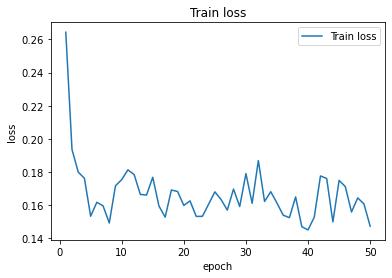

In [93]:
#plot train loss in each epoch
import matplotlib.pyplot as plt
%matplotlib inline
dim1 = []
dim1.extend(range(1, 51))
plt.plot(dim1,train_loss_list,label='Train loss')
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [94]:
#metrics
import medpy
from medpy import metric

def eval_metrics(pred,gt):
    Dice = metric.binary.dc(pred, gt)
    jaccard = metric.binary.jc(pred, gt)
    HD95 = metric.binary.hd95(pred, gt)
    ASD = metric.binary.asd(pred, gt)
    
    return Dice,jaccard,HD95,ASD

In [96]:
import torch
import numpy as np
import math
from glob import glob
import time


from dataset import read_h5


if __name__ == '__main__':
    model = Res3DUnet(n_channels=1, n_classes=2,drop=False)
    model = model.to(device)
    patch_size = (112, 112, 80)
    stride_xy = 18
    stride_z = 4
    total_metric = 0.0
    path_list = glob('./datas/test/*.h5')
    model.eval()
    for path in path_list:
        image, label = read_h5(path)
        #print(label)
        w, h, d = image.shape
        sx = math.ceil((w - patch_size[0]) / stride_xy) + 1
        sy = math.ceil((h - patch_size[1]) / stride_xy) + 1
        sz = math.ceil((d - patch_size[2]) / stride_z) + 1
        #print(sx, sy, sz)
        scores = np.zeros((2, ) + image.shape).astype(np.float32)
        counts = np.zeros(image.shape).astype(np.float32)
        
        # inference all windows (patches)
        for x in range(0, sx):
            xs = min(stride_xy * x, w - patch_size[0])
            for y in range(0, sy):
                ys = min(stride_xy * y, h - patch_size[1])
                for z in range(0, sz):
                    zs = min(stride_z * z, d - patch_size[2])

                    # extract one patch for model inference
                    test_patch = image[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]]
                    with torch.no_grad():
                        test_patch = torch.from_numpy(test_patch) # if use cuda
                        test_patch = test_patch.unsqueeze(0).unsqueeze(0) # [1, 1, w, h, d]
                        out = model(test_patch)
                        out = torch.softmax(out, dim=1)
                        out = out.data.numpy() # [1, 2, w, h, d]
                    
                    # record the predicted scores
                    scores[:, xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += out[0, ...]
                    counts[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += 1
        
        scores = scores / np.expand_dims(counts, axis=0)
        predictions = np.argmax(scores, axis = 0) # final prediction: [w, h, d]
        metrics = eval_metrics(predictions, label[:])
        total_metric += np.asarray(metrics)
        print('Metrics:', metrics)
        avrage_metric = total_metric / len(path_list)
        print('the of average of 4 metrics is = {}'.format(avrage_metric))

Metrics: (0.17560968890067447, 0.09625664411408603, 60.73713855624086, 38.52749308696737)
the of average of 4 metrics is = [0.00878048 0.00481283 3.03685693 1.92637465]
Metrics: (0.1843661492538913, 0.10154368358913814, 55.60575509783138, 34.96597785237338)
the of average of 4 metrics is = [0.01799879 0.00989002 5.81714468 3.67467355]
Metrics: (0.18553799208239877, 0.10225509890688463, 58.90670590009256, 37.73803550464329)
the of average of 4 metrics is = [0.02727569 0.01500277 8.76247998 5.56157532]
Metrics: (0.16340730569994383, 0.08897307835704965, 60.99508163674453, 38.35136113282454)
the of average of 4 metrics is = [ 0.03544606  0.01945143 11.81223406  7.47914338]
Metrics: (0.09083640513209361, 0.04757916261145683, 64.50581369148055, 40.83794878134267)
the of average of 4 metrics is = [ 0.03998788  0.02183038 15.03752474  9.52104082]
Metrics: (0.2306114074681986, 0.1303339517625232, 62.07253821135398, 36.57516508247673)
the of average of 4 metrics is = [ 0.05151845  0.02834708 18